# Model

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# First of all, we import all the packages that are required in this porject. 
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import stats
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data = pd.read_csv("bank-full.csv")

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Data Pre-Processing

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [4]:
data = data.drop("duration",axis=1)

In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [6]:
data_dup = data[data.duplicated(keep="last")]
data_dup

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
2807,44,services,single,secondary,no,0,yes,no,unknown,14,may,1,-1,0,unknown,no
4878,34,management,single,tertiary,no,0,yes,no,unknown,21,may,1,-1,0,unknown,no
12754,25,blue-collar,married,primary,no,0,no,no,cellular,7,jul,1,-1,0,unknown,no
13576,47,services,married,secondary,no,0,yes,no,cellular,9,jul,1,-1,0,unknown,no
15760,35,management,married,tertiary,no,0,yes,no,cellular,21,jul,3,-1,0,unknown,no
21489,47,technician,married,secondary,no,0,no,no,cellular,19,aug,2,-1,0,unknown,no
22093,31,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22142,32,technician,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22160,34,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22318,32,management,single,tertiary,no,0,no,no,cellular,22,aug,2,-1,0,unknown,no


In [7]:
data_dup.shape

(16, 16)

In [8]:
data = data.drop_duplicates()
data.shape

(45195, 16)

In [9]:
data_x = data.iloc[:, :-1]
data_y = data["y"]

In [10]:
data_x.shape

(45195, 15)

In [11]:
data_y.shape

(45195,)

In [12]:
X_rest, X_test, y_rest, y_test = train_test_split(data_x, data_y, test_size = 0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_rest, y_rest, test_size = 0.2)

In [13]:
y_train.replace({"no":0, "yes":1}, inplace=True)
y_cv.replace({"no":0, "yes":1}, inplace=True)
y_test.replace({"no":0, "yes":1}, inplace=True)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def add_onehot_to_dataframe(sparse, df, vectorizer, name):
  '''
      This function will add the one hot encoded to the dataframe.

  '''
  for i, col in enumerate(vectorizer.get_feature_names()):
    colname = name+"_"+col
    # df[colname] = pd.SparseSeries(sparse[:, i].toarray().flatten(), fill_value=0)
    df[colname] = sparse[:, i].toarray().ravel().tolist()
  
  return df

def OneHotEncoder(categorical_cols, X_train, X_test, X_cv=None, include_cv=False):
  '''
    This function takes categorical column names as inputs. The objective
    of this function is to take the column names iteratively and encode the 
    features using One hot Encoding mechanism and also adding the encoded feature
    to the respective dataframe.

    The include_cv parameter indicates whether we should include CV dataset or not.
    This is added specifically because when using GridSearchCV or RandomizedSearchCV,
    we only split the dataset into train and test to give more data to training purposes.
    This is done because GridSearchCV splits the data internally anyway.
  '''

  for i in categorical_cols:
    Vectorizer = CountVectorizer(token_pattern="[A-Za-z0-9-.]+")
    print("Encoding for feature: ", i)
    # Encoding training dataset 
    temp_cols = Vectorizer.fit_transform(X_train[i])
    X_train = add_onehot_to_dataframe(temp_cols, X_train, Vectorizer, i)

    # Encoding Cross validation dataset
    if include_cv:
      temp_cols = Vectorizer.transform(X_cv[i])
      X_cv = add_onehot_to_dataframe(temp_cols, X_cv, Vectorizer, i)

    # Encoding Test dataset
    temp_cols = Vectorizer.transform(X_test[i])
    X_test = add_onehot_to_dataframe(temp_cols, X_test, Vectorizer, i)


In [15]:
categorical_cols = data.drop("y",axis=1).select_dtypes(include=["object"]).columns.to_list()
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [16]:
OneHotEncoder(categorical_cols, X_train, X_test, X_cv, True)

# Drop the categorical features as the one hot encoded representation is present
X_train = X_train.drop(categorical_cols, axis=1)
X_cv = X_cv.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)

print("Shape of train: ", X_train.shape)
print("Shape of CV: ", X_cv.shape)
print("Shape of test: ", X_test.shape)

Encoding for feature:  job
Encoding for feature:  marital
Encoding for feature:  education
Encoding for feature:  default
Encoding for feature:  housing
Encoding for feature:  loan
Encoding for feature:  contact
Encoding for feature:  month
Encoding for feature:  poutcome
Shape of train:  (28924, 50)
Shape of CV:  (7232, 50)
Shape of test:  (9039, 50)


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28924 entries, 24349 to 38517
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  28924 non-null  int64
 1   balance              28924 non-null  int64
 2   day                  28924 non-null  int64
 3   campaign             28924 non-null  int64
 4   pdays                28924 non-null  int64
 5   previous             28924 non-null  int64
 6   job_admin.           28924 non-null  int64
 7   job_blue-collar      28924 non-null  int64
 8   job_entrepreneur     28924 non-null  int64
 9   job_housemaid        28924 non-null  int64
 10  job_management       28924 non-null  int64
 11  job_retired          28924 non-null  int64
 12  job_self-employed    28924 non-null  int64
 13  job_services         28924 non-null  int64
 14  job_student          28924 non-null  int64
 15  job_technician       28924 non-null  int64
 16  job_unemployed    

# Models

## 1 - Logistic Regression

In [19]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

print("AUC score without duration column: ", roc_auc_score(y_test, y_pred[:,1]))
     

AUC score without duration column:  0.7397412909806098


- On one hot encoded data:

AUC for k =  1e-05 is 0.6541700058618805
AUC for k =  0.0001 is 0.7110057042421702
AUC for k =  0.001 is 0.7435771818985886
AUC for k =  0.01 is 0.7448407428069251
AUC for k =  0.1 is 0.7435590582100781
AUC for k =  1 is 0.7417576390875101
AUC for k =  10 is 0.7456636715383519
AUC for k =  100 is 0.740349277459512
AUC for k =  1000 is 0.7420519602373825


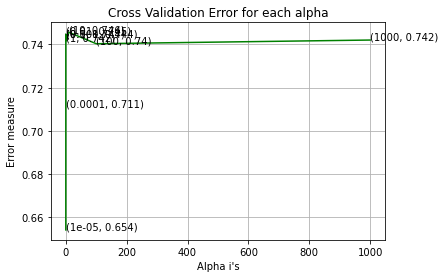

For values of best alpha =  10 The train AUC is: 0.7381050303672549
For values of best alpha =  10 The cross validation AUC is: 0.7456636715383519
For values of best alpha =  10 The test AUC is: 0.7384804571338721


In [22]:
%matplotlib inline

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for k = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

- On Response coded data:

AUC for k =  1e-05 is 0.6541700058618805
AUC for k =  0.0001 is 0.7110057042421702
AUC for k =  0.001 is 0.7435771818985886
AUC for k =  0.01 is 0.7448407428069251
AUC for k =  0.1 is 0.7435590582100781
AUC for k =  1 is 0.7417576390875101
AUC for k =  10 is 0.7456636715383519
AUC for k =  100 is 0.740349277459512
AUC for k =  1000 is 0.7420519602373825


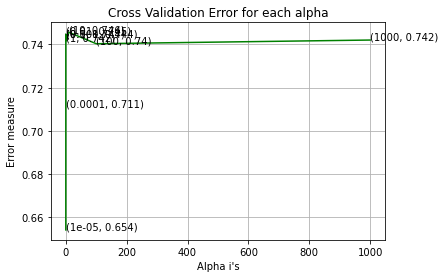

For values of best alpha =  10 The train AUC is: 0.7381050303672549
For values of best alpha =  10 The cross validation AUC is: 0.7456636715383519
For values of best alpha =  10 The test AUC is: 0.7384804571338721


In [24]:
%matplotlib inline

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for k = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

## 2 - SVM

- On one hot encoded data:

AUC for alpha =  1e-05 is 0.5
AUC for alpha =  0.0001 is 0.5
AUC for alpha =  0.001 is 0.5
AUC for alpha =  0.01 is 0.5648391003476538
AUC for alpha =  0.1 is 0.6541664188818628
AUC for alpha =  1 is 0.6841044868400311
AUC for alpha =  10 is 0.6170981898022159
AUC for alpha =  100 is 0.6209962931393344
AUC for alpha =  1000 is 0.6316267803928121


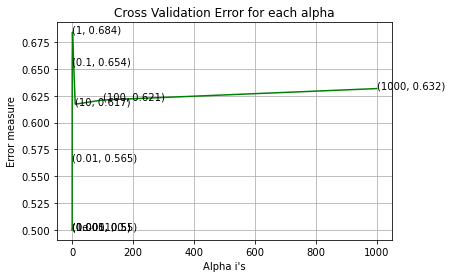

For values of best alpha =  1 The train AUC is: 0.5620997406749615
For values of best alpha =  1 The cross validation AUC is: 0.5643176667261349
For values of best alpha =  1 The test AUC is: 0.5696721551215218


In [27]:
%matplotlib inline

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    linearSVM = SGDClassifier(penalty='l2',alpha=i,class_weight='balanced')
    linearSVM.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for alpha = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

linearSVM = SGDClassifier(penalty='l2', alpha=alpha[best_alpha], class_weight='balanced')
linearSVM.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

- On Response coded data:

AUC for alpha =  1e-05 is 0.5
AUC for alpha =  0.0001 is 0.5
AUC for alpha =  0.001 is 0.5
AUC for alpha =  0.01 is 0.6460870295746503
AUC for alpha =  0.1 is 0.5970143111063284
AUC for alpha =  1 is 0.6771259228214053
AUC for alpha =  10 is 0.5961003863555057
AUC for alpha =  100 is 0.6300587037598158
AUC for alpha =  1000 is 0.6361920620132209


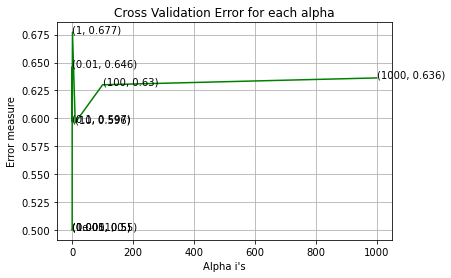

For values of best alpha =  1 The train AUC is: 0.5828714780764522
For values of best alpha =  1 The cross validation AUC is: 0.5855742990993849
For values of best alpha =  1 The test AUC is: 0.5871950196536586


In [28]:
%matplotlib inline

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    linearSVM = SGDClassifier(penalty='l2',alpha=i,class_weight='balanced')
    linearSVM.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for alpha = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

linearSVM = SGDClassifier(penalty='l2', alpha=alpha[best_alpha], class_weight='balanced')
linearSVM.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

## 3 - Random Forest

- On one hot encoded data:

AUC for number of estimators =  10 is 0.7873821370283004
AUC for number of estimators =  50 is 0.8009095826171173
AUC for number of estimators =  100 is 0.7996275204434262
AUC for number of estimators =  500 is 0.7985040405442015
AUC for number of estimators =  1000 is 0.7987188817684189
AUC for number of estimators =  2000 is 0.7984657164945388
AUC for number of estimators =  3000 is 0.7988030814046237


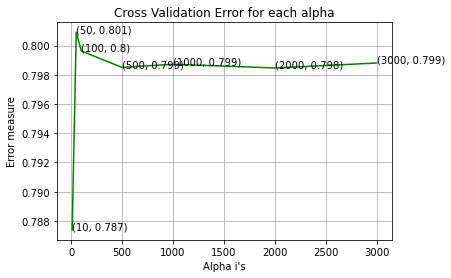

For values of best alpha =  50 The train AUC is: 0.9999971226551445
For values of best alpha =  50 The cross validation AUC is: 0.8009095826171173
For values of best alpha =  50 The test AUC is: 0.7792199443159991


In [31]:
%matplotlib inline

alpha=[10,50,100,500,1000,2000,3000]
cv_auc_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

- On Response coded data:

AUC for number of estimators =  10 is 0.7873821370283004
AUC for number of estimators =  50 is 0.8009095826171173
AUC for number of estimators =  100 is 0.7996275204434262
AUC for number of estimators =  500 is 0.7985040405442015
AUC for number of estimators =  1000 is 0.7987188817684189
AUC for number of estimators =  2000 is 0.7984657164945388
AUC for number of estimators =  3000 is 0.7988030814046237


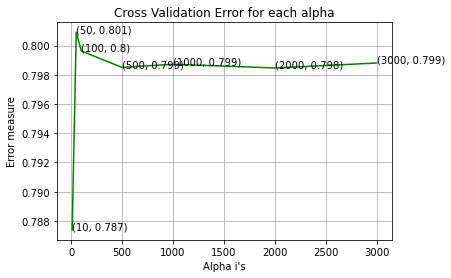

For values of best alpha =  50 The train AUC is: 0.9999971226551445
For values of best alpha =  50 The cross validation AUC is: 0.8009095826171173
For values of best alpha =  50 The test AUC is: 0.7792199443159991


In [32]:
%matplotlib inline

alpha=[10,50,100,500,1000,2000,3000]
cv_auc_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

## 4 - XGBoost

- On one hot encoded data:

In [38]:
x_cfl=XGBClassifier(tree_method='gpu_hist', max_bin=16)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_iter=20, cv=10, scoring='roc_auc')
random_cfl.fit(X_train, y_train)
print (random_cfl.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.3
[21:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10; 1/20] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.3; total time=  10.1s
[CV 2/10; 1/20] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=2000, subsample=0.3
[21:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[CV 6/10; 2/20] END colsample_bytree=0.1, learning_rate=0.03, max_depth=3, n_estimators=2000, subsample=0.5; total time=   7.6s
[CV 7/10; 2/20] START colsample_bytree=0.1, learning_rate=0.03, max_depth=3, n_estimators=2000, subsample=0.5
[21:14:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 7/10; 2/20] END colsample_bytree=0.1, learning_rate=0.03, max_depth=3, n_estimators=2000, subsample=0.5; total time=   9.2s
[CV 8/10; 2/20] START colsample_bytree=0.1, learning_rate=0.03, max_depth=3, n_estimators=2000, subsample=0.5
[21:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed f

[CV 2/10; 4/20] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1; total time=   4.4s
[CV 3/10; 4/20] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1
[21:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10; 4/20] END colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1; total time=   4.0s
[CV 4/10; 4/20] START colsample_bytree=0.1, learning_rate=0.05, max_depth=3, n_estimators=1000, subsample=1
[21:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[CV 8/10; 5/20] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1; total time=   2.0s
[CV 9/10; 5/20] START colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1
[21:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 9/10; 5/20] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1; total time=   2.2s
[CV 10/10; 5/20] START colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1
[21:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'log

[CV 4/10; 7/20] END colsample_bytree=0.3, learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.1; total time=   6.8s
[CV 5/10; 7/20] START colsample_bytree=0.3, learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.1
[21:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/10; 7/20] END colsample_bytree=0.3, learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.1; total time=   6.3s
[CV 6/10; 7/20] START colsample_bytree=0.3, learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.1
[21:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed f

[CV 10/10; 8/20] END colsample_bytree=1, learning_rate=0.03, max_depth=5, n_estimators=100, subsample=0.1; total time=   1.1s
[CV 1/10; 9/20] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.3
[21:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/10; 9/20] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.3; total time=   2.3s
[CV 2/10; 9/20] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.3
[21:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[CV 6/10; 10/20] END colsample_bytree=1, learning_rate=0.03, max_depth=3, n_estimators=1000, subsample=0.1; total time=   6.6s
[CV 7/10; 10/20] START colsample_bytree=1, learning_rate=0.03, max_depth=3, n_estimators=1000, subsample=0.1
[21:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 7/10; 10/20] END colsample_bytree=1, learning_rate=0.03, max_depth=3, n_estimators=1000, subsample=0.1; total time=   9.4s
[CV 8/10; 10/20] START colsample_bytree=1, learning_rate=0.03, max_depth=3, n_estimators=1000, subsample=0.1
[21:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 

[CV 1/10; 12/20] END colsample_bytree=0.3, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.3; total time=  39.7s
[CV 2/10; 12/20] START colsample_bytree=0.3, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.3
[21:24:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/10; 12/20] END colsample_bytree=0.3, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.3; total time=  41.3s
[CV 3/10; 12/20] START colsample_bytree=0.3, learning_rate=0.2, max_depth=10, n_estimators=1000, subsample=0.3
[21:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[CV 6/10; 13/20] END colsample_bytree=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=1; total time=   3.3s
[CV 7/10; 13/20] START colsample_bytree=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=1
[21:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 7/10; 13/20] END colsample_bytree=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=1; total time=   6.2s
[CV 8/10; 13/20] START colsample_bytree=0.1, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=1
[21:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[CV 2/10; 15/20] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.3; total time=   1.9s
[CV 3/10; 15/20] START colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.3
[21:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10; 15/20] END colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.3; total time=   1.9s
[CV 4/10; 15/20] START colsample_bytree=1, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.3
[21:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[CV 7/10; 16/20] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.1; total time=  12.1s
[CV 8/10; 16/20] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.1
[21:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 8/10; 16/20] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.1; total time=   7.7s
[CV 9/10; 16/20] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.1
[21:34:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[CV 2/10; 18/20] END colsample_bytree=0.1, learning_rate=0.03, max_depth=5, n_estimators=500, subsample=0.3; total time=   3.6s
[CV 3/10; 18/20] START colsample_bytree=0.1, learning_rate=0.03, max_depth=5, n_estimators=500, subsample=0.3
[21:45:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/10; 18/20] END colsample_bytree=0.1, learning_rate=0.03, max_depth=5, n_estimators=500, subsample=0.3; total time=   3.1s
[CV 4/10; 18/20] START colsample_bytree=0.1, learning_rate=0.03, max_depth=5, n_estimators=500, subsample=0.3
[21:45:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed f

[CV 7/10; 19/20] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=2000, subsample=0.5; total time=  16.8s
[CV 8/10; 19/20] START colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=2000, subsample=0.5
[21:47:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 8/10; 19/20] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=2000, subsample=0.5; total time=  10.4s
[CV 9/10; 19/20] START colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=2000, subsample=0.5
[21:47:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

In [39]:
x_cfl=XGBClassifier(n_estimators=200,max_depth=5,learning_rate=0.1, \
                    colsample_bytree=0.5,subsample=1,tree_method='gpu_hist', max_bin=16)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ("For values of best alpha = 200 The train AUC is:",roc_auc_score(y_train, predict_y[:, 1]))
predict_y = sig_clf.predict_proba(X_test)
print("For values of best alpha = 200 The test AUC is:",roc_auc_score(y_test, predict_y[:, 1]))

[21:48:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:48:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

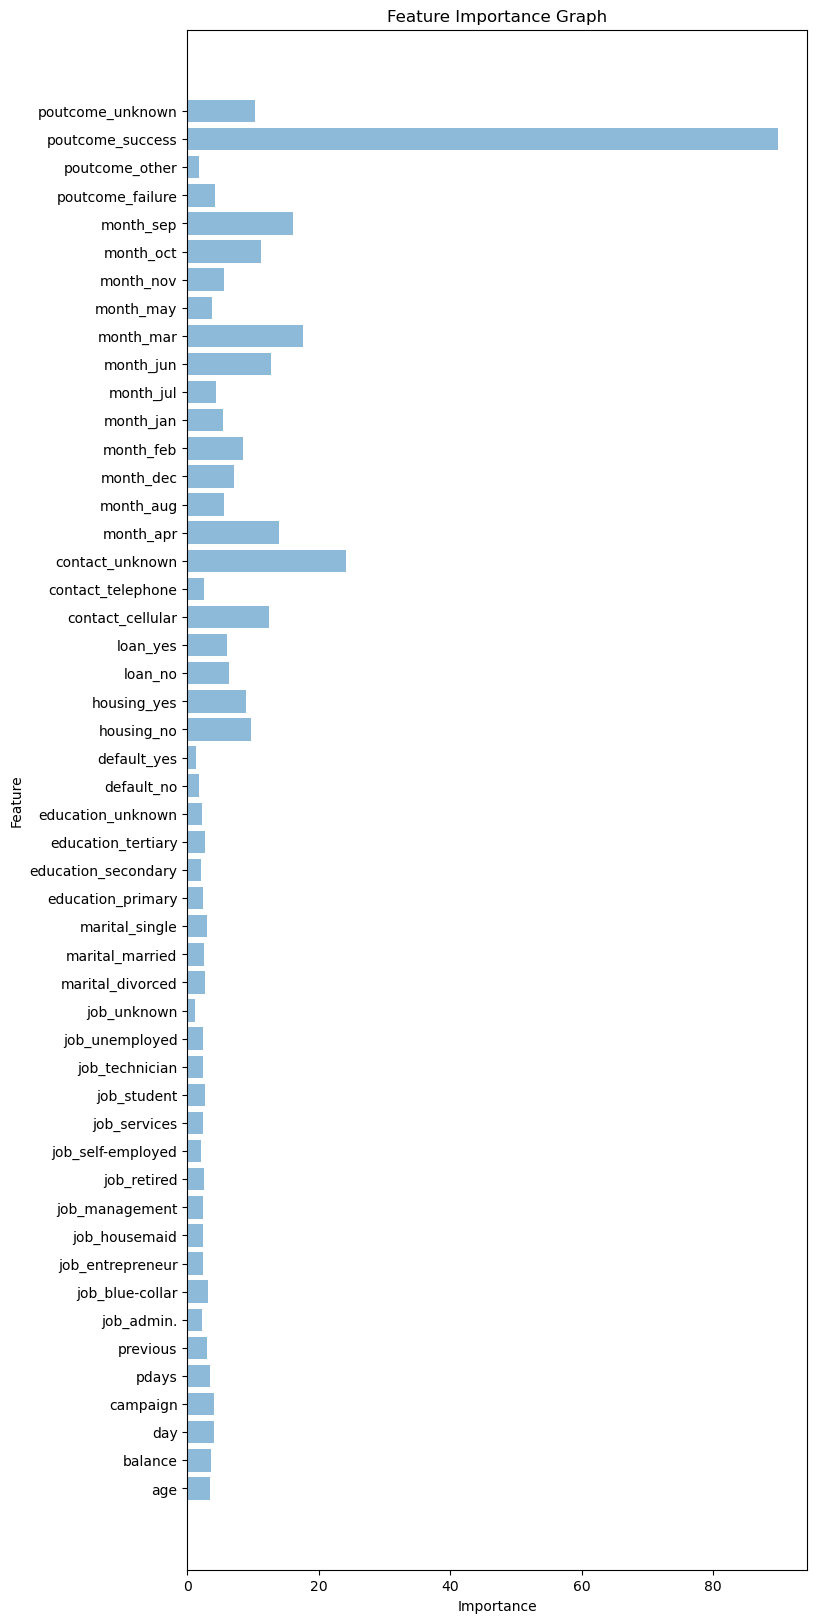

In [40]:
import matplotlib.pyplot as plt; plt.rcdefaults()
feature_importance = x_cfl.get_booster().get_score(importance_type='gain')

objects = feature_importance.keys()
y_pos = np.arange(len(objects))
performance = feature_importance.values()
plt.figure(figsize=(8,20))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Graph')
plt.show()

- On Response coded data:

In [41]:
x_cfl=XGBClassifier(tree_method='gpu_hist', max_bin=16)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_iter=20, cv=5, scoring='roc_auc')
random_cfl.fit(X_train, y_train)
print (random_cfl.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1
[21:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/20] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.6s
[CV 2/5; 1/20] START colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1
[21:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

[CV 1/5; 4/20] END colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.1; total time=   6.6s
[CV 2/5; 4/20] START colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.1
[21:49:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 4/20] END colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.1; total time=  10.6s
[CV 3/5; 4/20] START colsample_bytree=0.3, learning_rate=0.2, max_depth=5, n_estimators=1000, subsample=0.1
[21:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[CV 2/5; 7/20] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.1; total time=   1.0s
[CV 3/5; 7/20] START colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.1
[21:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 7/20] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.1; total time=   1.1s
[CV 4/5; 7/20] START colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.1
[21:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logl

[CV 3/5; 10/20] END colsample_bytree=0.5, learning_rate=0.03, max_depth=5, n_estimators=1000, subsample=0.1; total time=   8.6s
[CV 4/5; 10/20] START colsample_bytree=0.5, learning_rate=0.03, max_depth=5, n_estimators=1000, subsample=0.1
[22:02:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 10/20] END colsample_bytree=0.5, learning_rate=0.03, max_depth=5, n_estimators=1000, subsample=0.1; total time=   8.6s
[CV 5/5; 10/20] START colsample_bytree=0.5, learning_rate=0.03, max_depth=5, n_estimators=1000, subsample=0.1
[22:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed f

[CV 3/5; 13/20] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   2.2s
[CV 4/5; 13/20] START colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5
[22:09:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 13/20] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5; total time=   2.0s
[CV 5/5; 13/20] START colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5
[22:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 

[CV 4/5; 16/20] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1; total time=   0.9s
[CV 5/5; 16/20] START colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1
[22:10:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 16/20] END colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1; total time=   1.0s
[CV 1/5; 17/20] START colsample_bytree=0.1, learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.3
[22:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error

[CV 5/5; 19/20] END colsample_bytree=1, learning_rate=0.03, max_depth=5, n_estimators=100, subsample=0.5; total time=   1.3s
[CV 1/5; 20/20] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.1
[22:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 20/20] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.1; total time=   1.8s
[CV 2/5; 20/20] START colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.1
[22:11:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

In [42]:
x_cfl=XGBClassifier(n_estimators=2000,max_depth=3,learning_rate=0.01, \
                    colsample_bytree=0.5,subsample=1,tree_method='gpu_hist', max_bin=16)
x_cfl.fit(X_train,y_train,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ("For values of best alpha = 2000 The train AUC is:",roc_auc_score(y_train, predict_y[:, 1]))
predict_y = sig_clf.predict_proba(X_test)
print("For values of best alpha = 2000 The test AUC is:",roc_auc_score(y_test, predict_y[:, 1]))

[22:11:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

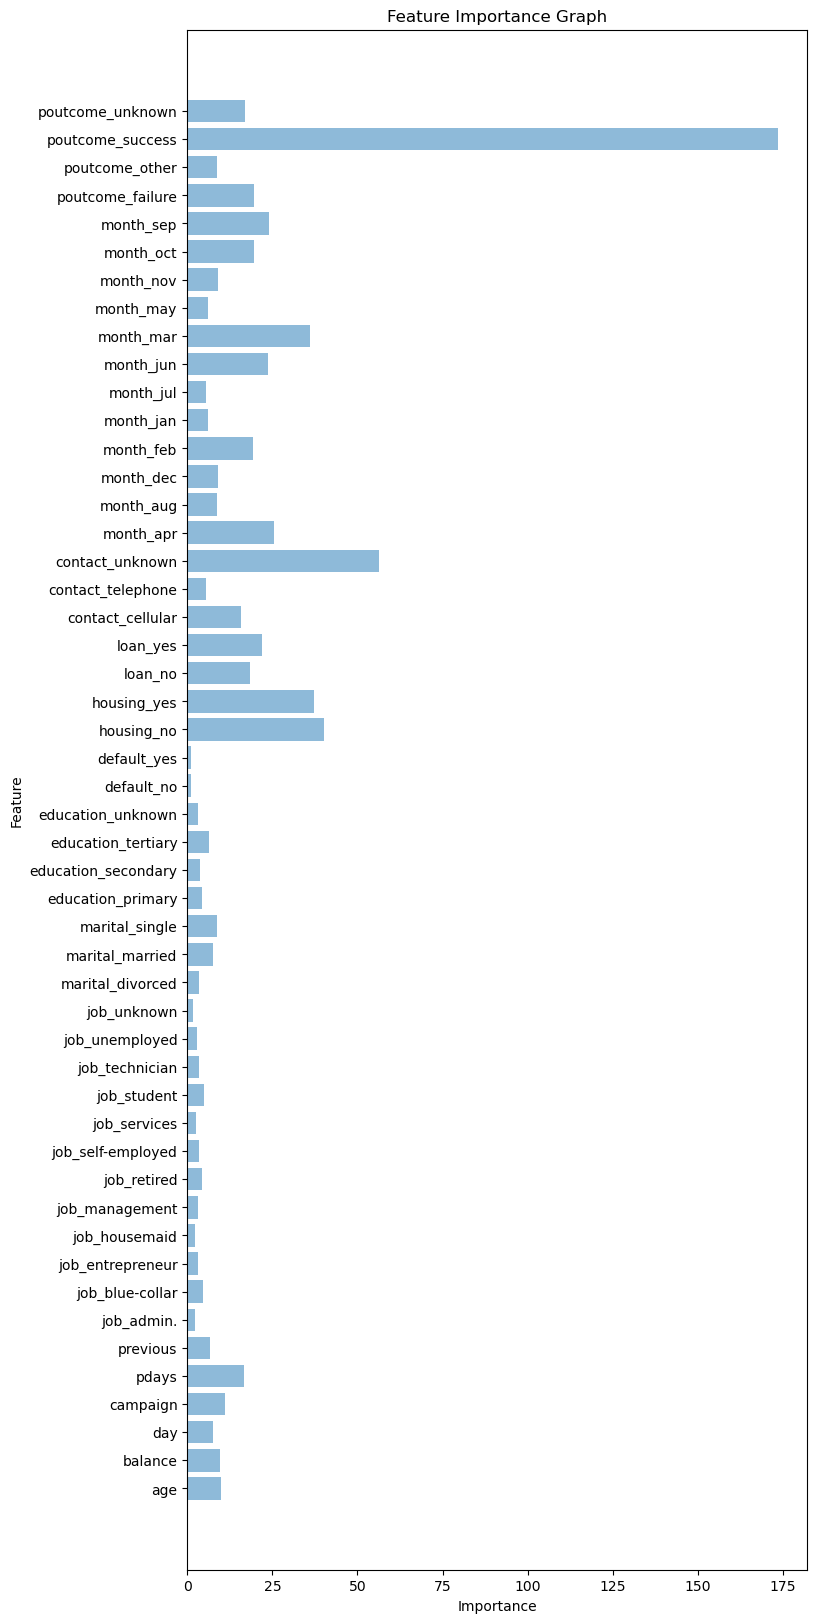

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
feature_importance = x_cfl.get_booster().get_score(importance_type='gain')

objects = feature_importance.keys()
y_pos = np.arange(len(objects))
performance = feature_importance.values()
plt.figure(figsize=(8,20))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Graph')
plt.show()

In [55]:
performance = {
    'Encoding': ['One Hot Encoding', "", "", "", 'Response Coding', "", "", ""],
    'Model': ["Logistic Regression", "SVM", "Random Forest", "XGBoost","Logistic Regression", "SVM", "Random Forest", "XGBoost"],
    'Train AUC': [ 0.74, 0.56, 1, 0.86, 0.74, 0.56, 1, 0.86 ],
    'Test AUC': [ 0.74, 0.57, 0.78, 0.79, 0.74, 0.59, 0.78, 0.79 ]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(performance)

# Display the DataFrame
df


,Encoding,Model,Train AUC,Test AUC
0,One Hot Encoding,Logistic Regression,0.74,0.74
1,,SVM,0.56,0.57
2,,Random Forest,1.00,0.78
3,,XGBoost,0.86,0.79
4,Response Coding,Logistic Regression,0.74,0.74
5,,SVM,0.56,0.59
6,,Random Forest,1.00,0.78
7,,XGBoost,0.86,0.79
